# The away goal rule was not fair enough.

<sub>Wouter Kool Washington University in St. Louis</sub>

Last week, it was announced that UEFA will abolish the "away goal" rule for Champions League games. This rule was introduced in 1965, when the Champions League was still the European Cup, and was meant to give teams some extra motivation to score during away games in either a playoff or knockout round. After two legs of football matches, if the aggregate score was a tie, the team with the most away goals would win. This rule also counted in extra time, the extra 30 minutes played in the second leg of the match after a tie with no winner, so that if the away team would score during this period, the home team would need to score at least twice. This last aspect of the rule has often been framed as particularly unfair for the home team. Indeed, at first glance, it certainly sounds like it overly punishes them! I think this feeling is one of the main reasons that the rule was recently abolished. Here, I will show that this was a mistake, but also how this mistake can be salvaged without reintroducing the rule!

Over the first 180 minutes of football, the away goal rule is not unfair: both teams get 90 minutes to take advantage of it. However, after regular time, something interesting happens. The home team gets to play 30 more minutes in their own stadium, and the away team gets an extra 30 minutes of 'away goal advantage'. So, which team gets the advantage? Like I said above, most people in the business seem to think that the advantage goes to the away team. In the end, their goals count more than their opponent's goals. The great thing is that we do not have to rely on intuition, feelings, or opinion, because we can simply look at the data. If the rule truly is unfair, then we should find that the away team wins more during overtime. However, if they win equally, the away goal rule is doing its work, and if the home team wins more often, the away goal rule is not punitive enough.

So, what happens in overtime? I analyzed all games from the Europa Cup 1 and Champions Leauge that went into overtime since the rule has been introduced in 1965. The hypothesis is simple: if the away goal rule is unfair to the home team in overtime, then the away team should win games that go to overtime more (than 50%). (I decided to not analyze data from the last two seasons, since I suspect that COVID has had a huge, and unrelated, effect on the home-field advantage.)

The results were very surprising, and speak strongly against this rule change! Across all games played so far, there is an overwhelming tendency for the away team to lose in extra time: 63% of games are won by the home team after regular time. So, home teams win most of the time, even with the away goal rule in place. This clearly shows that, if anything, the away goal rule was not fair enough.

You can see the data for yourself in the figure below (and you can find all data and code for this analysis on my GitHub profile). As you can see, there seems to be somewhat of a downward trend over time, but even in the last decade, there is a clear (60%) advantage for the home team during overtime. Now that this rule has been abolished, the home team's chances of winning will be even greater during overtime! That's not fair at all. The home team is clearly at an advantage, so taking away the away goal rule will benefit them even more.

Luckily, I discovered an easy fix, which I will tell you about below!

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from statsmodels.stats.descriptivestats import sign_test
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# load data
dirs = [f for f in os.listdir('data') if not f.startswith('.')]

data = pd.DataFrame()

for i in range(0,len(dirs)) :
    tempdata = pd.read_csv('data/'+dirs[i]+'/champs.csv')
    tempdata = tempdata[~tempdata['ET'].isnull().values]
    tempdata['year'] = int(dirs[i][0:4:1])
    tempdata = tempdata[tempdata["Round"]!="Final"]
    data = data.append(tempdata)

remaining = pd.read_csv('remaining_games.csv')
data = data.append(remaining)

data["home_goals"] = ""
data["away_goals"] = ""
data["penalties"] = ""
data["home_wins"] = np.nan
data["sign"] = np.nan
data.reset_index(inplace=True)

nrdatasets=len(data)

for i in range(0,nrdatasets) :
    if (isinstance(data.iloc[i]['P'],str)) : # penalties
        middle = data.iloc[i]['P'].find('-')
        end = data.iloc[i]['P'].find(' ')
        home_goals = int(data.iloc[i]['P'][0: middle: 1])
        away_goals = int(data.iloc[i]['P'][(middle+1): end: 1])
        home_wins = home_goals > away_goals
        data.at[i,"penalties"] = True
    else : # no penalties
        ft_middle = data.iloc[i]['FT'].find('-')
        ft_end = data.iloc[i]['FT'].find(' ')
        ft_home_goals = int(data.iloc[i]['FT'][0: ft_middle: 1])
        ft_away_goals = int(data.iloc[i]['FT'][(ft_middle+1): ft_end: 1])
        et_middle = data.iloc[i]['ET'].find('-')
        et_end = data.iloc[i]['ET'].find(' ')
        home_goals = int(data.iloc[i]['ET'][0: et_middle: 1])
        away_goals = int(data.iloc[i]['ET'][(et_middle+1): et_end: 1])
        home_wins = (home_goals-ft_home_goals) > (away_goals-ft_away_goals)
        data.at[i,"penalties"] = False
    data.at[i,"home_wins"] = float(home_wins)
    if (home_wins==1) :
        data.at[i,"sign"] = 1
    else :
        data.at[i,"sign"] = -1
    data.at[i,"home_goals"] = home_goals
    data.at[i,"away_goals"] = away_goals
    if (data.iloc[i]["year"] <= 1984) :
        data.at[i,"year_range"] = "1965 - 1984"
    elif ((data.iloc[i]["year"] > 1984) & (data.iloc[i]["year"] <= 2004)) :
        data.at[i,"year_range"] = "1985 - 2004"
    else :
        data.at[i,"year_range"] = "2005 - 2018"

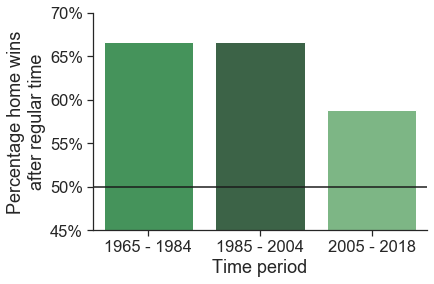

In [7]:
year=data.groupby(['year_range'])["home_wins"]
pal = sns.color_palette("Greens_d", 3)
rank = year.mean().argsort().argsort()

order_list = ['1965 - 1984','1985 - 2004','2005 - 2018']

sns.set(style="ticks",font_scale=1.5)

ax=sns.barplot(x="year_range", y="home_wins",data=data, ci=None,palette=np.array(pal[::-1])[rank],order=order_list)
ax.set(xlabel='Time period', ylabel='Percentage home wins\nafter regular time',ylim=(0.45, 0.70))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.axhline(y=0.5, color='k')
sns.despine()

## Penalty kicks are completely fair

After 30 minutes of overtime, games are decided by penalty kicks. How does that affect this analysis? So far, I have only analyzed data across all games, not splitting them out by when the games was decided (extra time or penalty kicks). But, if we do this, we see another interesting pattern emerge.

It turns out that if games finish before the 30 minutes of extra time are over, the home team has an amazing 70% to win the game! However, if the game goes to a series of penalty kicks, the home team advantage evaporates, with only 53% of a chance for either team to win. I show these percentages in the graph below. As you can see, there is again a slight diminishing trend in this effect over time. However, there is still a huge benefit for the home team during extra time and much less during penalty kicks even in the last decade or so.

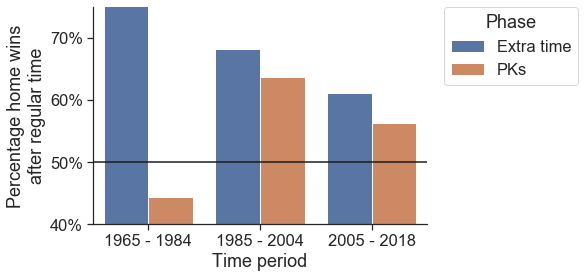

In [8]:
pal = sns.color_palette("Greens_d", 3)
rank = year.mean().argsort().argsort()

order_list = ['1965 - 1984','1985 - 2004','2005 - 2018']

sns.set(style="ticks",font_scale=1.5)

ax=sns.barplot(x="year_range", y="home_wins", data=data,hue="penalties", ci=None, order=order_list)
ax.set(xlabel='Time period', ylabel='Percentage home wins\nafter regular time',ylim=(0.40, 0.75))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Extra time', 'PKs'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Phase')

plt.axhline(y=0.5, color='k')

sns.despine()

Even though I am an AFC Ajax fan, still recovering from our 2019 semi-final against Tottenham (decided on away goals), I have to conclude that, if anything, the away goal rule was not fair enough. Now that this rule has been abolished, we should see an even stronger tendency for home-playing teams to win during extra time: there is a clear home advantage and eliminating the rule benefits home teams.

However, this last analysis has provided us with a great solution for this problem! This is because all of the home team's advantage takes place before penalty kicks are taken.

Therefore, UEFA should go one step further and eliminate extra time. After 180 minutes, games should go straight to penalty kicks. In this scenario, both teams would have had a home advantage for 50% of the time, and their chances of winning would not depend on which team gets to play home last. Moreover, it would spare the players, and it would allow the UEFA to keep the away goal rule, eh, away.

Now, of course, I am not expecting that UEFA will listen to a Dutch psychology professor in the USA, so we may have to live with the knowledge that they created an unfair system. Even so, as a psychological scientist this project has been interesting to me at many other levels. The most important insight to draw from this analysis is that decision making is hard, and that your intuition is often pretty wrong. The UEFA could really learn from this, so that in the future it will implement changes by more closely inspecting the data. But you, the reader, can also learn from this!

The lesson is that your subjective experience of the world is often inaccurate. Our minds are lazy, our decision-making systems are easily swayed by emotion, and your judgment rarely relies on an exhaustive analysis of the problem at hand. Normally, this is fine, because you simply do not have the time to think about every single decision you need to make in the world. However, as we have seen here, for important decisions, you might want to think a little harder, and perhaps even learn how to code. If you are interested in learning how to do this, you can find the code for this project on my GitHub profile: https://github.com/wkool/cl_awaygoals.

### Acknowledgements
I thank Gerald Bauer and github.com/footballcsv for providing the bulk of the data for this project.

### Supplemental analyses
Some smart Redditors have pointed out that home/away teams are not randomy selected in the Round of 16. You can see the data of the two graphs above when you exclude this round, it turns out that it doesn't make a huge difference, but the distinction between extra time and penalty kicks becomes a little bit more finnicky. (However, I would argue that RO16 games that end up in a symmetric tie were more likely to not feature overly imbalanced teams.)

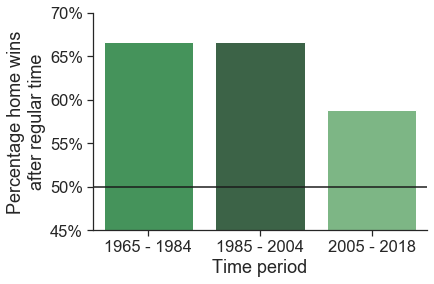

In [12]:
data_no16 = data[data["Round"]!="Round of 16 | Leg 2"]

year=data_no16.groupby(['year_range'])["home_wins"]
pal = sns.color_palette("Greens_d", 3)
rank = year.mean().argsort().argsort()

order_list = ['1965 - 1984','1985 - 2004','2005 - 2018']

sns.set(style="ticks",font_scale=1.5)

ax=sns.barplot(x="year_range", y="home_wins",data=data_no16, ci=None,palette=np.array(pal[::-1])[rank],order=order_list)
ax.set(xlabel='Time period', ylabel='Percentage home wins\nafter regular time',ylim=(0.45, 0.70))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.axhline(y=0.5, color='k')
sns.despine()

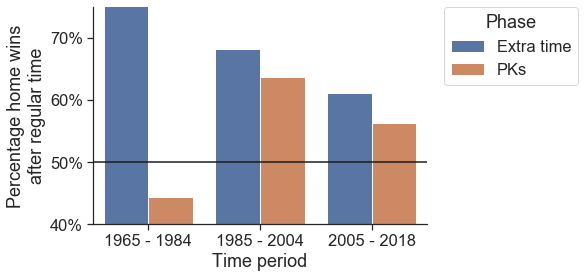

In [13]:
pal = sns.color_palette("Greens_d", 3)
rank = year.mean().argsort().argsort()

order_list = ['1965 - 1984','1985 - 2004','2005 - 2018']

sns.set(style="ticks",font_scale=1.5)

ax=sns.barplot(x="year_range", y="home_wins", data=data_no16,hue="penalties", ci=None, order=order_list)
ax.set(xlabel='Time period', ylabel='Percentage home wins\nafter regular time',ylim=(0.40, 0.75))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Extra time', 'PKs'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Phase')

plt.axhline(y=0.5, color='k')

sns.despine()

Here are the raw percentages for the analyses of win percentage of the home team for the three different time periods:

In [7]:
year=data.groupby(['year_range'])["home_wins"]
year.mean()*100

year_range
1965 - 1984    65.517241
1985 - 2004    64.102564
2005 - 2018    60.000000
Name: home_wins, dtype: float64

And here are the same values split by both year and phase of the game:

In [8]:
yearxpen=data.groupby(['year_range','penalties'])["home_wins"]
yearxpen.mean()*100

year_range   penalties
1965 - 1984  False        73.684211
             True         50.000000
1985 - 2004  False        70.833333
             True         53.333333
2005 - 2018  False        65.217391
             True         54.545455
Name: home_wins, dtype: float64

In [15]:
# jupyter nbconvert --to html --TemplateExporter.exclude_input=True awaygoal.ipynb

os.system('jupyter nbconvert --to markdown --TemplateExporter.exclude_input=True awaygoal.ipynb')

0